**Link to dataset**


https://zenodo.org/record/5550238#.YajObJFBzeQ

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/PythonforDataScience/
!ls

/content/drive/MyDrive/PythonforDataScience
'Assignment with Mario.ipynb'   housing_data.data
 Data			        housing.names
 data_linear.csv	       'Mario assignment.ipynb'
 data_linear_missing.csv        UN_dataset_osdg_community.csv
 dataset.csv		       'Vân Thiênn'
 data_square.csv	        winequality-white.csv
 googleplaystore.csv	        zzz.pynb


In [3]:
#import các thư viện chính
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

#import thư viện cho NLP
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

#import thư viện cho sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

#Loại bỏ thông báo linh tinh
import warnings
warnings.filterwarnings("ignore")

In [22]:
#Loading UN sustainable development goals dataset
df = pd.read_csv("UN_dataset_osdg_community.csv", delimiter="\t")
df.head()

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,8,0.777778
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,8,0.777778
3,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333
4,10.1787/9789264258211-6-en,0006d6e7593776abbdf4a6f985ea6d95,A region reporting a higher rate will not earn...,3,2,2,0.000000


In [26]:
df.dtypes
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32327 entries, 0 to 32326
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doi              32327 non-null  object 
 1   text_id          32327 non-null  object 
 2   text             32327 non-null  object 
 3   sdg              32327 non-null  int64  
 4   labels_negative  32327 non-null  int64  
 5   labels_positive  32327 non-null  int64  
 6   agreement        32327 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.7+ MB


,sdg,labels_negative,labels_positive,agreement
count,32327.000000,32327.000000,32327.000000,32327.000000
mean,6.513967,1.501872,4.893216,0.692060
std,3.950474,7.418859,13.021928,0.318663
min,1.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,3.000000,0.333333
50%,6.000000,1.000000,4.000000,0.777778
75%,9.000000,2.000000,7.000000,1.000000
max,15.000000,837.000000,925.000000,1.000000


**Dataset này chứa nhiều dòng mà số negative labels nhiều hơn positive labels cùng với độ đồng thuận thấp. Những entries này làm giảm độ chính xác của model nên sẽ được loại bỏ.
Chỉ lấy entries nào có agreement >= 0.6 và positive lables > negative lables**

In [5]:
#Keeping only the texts whose suggested sdg labels is accepted and the agreement score is at least 0.6
df_filtered = df[(df["agreement"] >= 0.6) & (df["labels_positive"] > df["labels_negative"])]
print(df_filtered.head())
df_filtered.info()

                           doi                           text_id  \
0   10.6027/9789289342698-7-en  00021941702cd84171ff33962197ca1f   
2   10.1787/9789264289062-4-en  0004eb64f96e1620cd852603d9cbe4d4   
7   10.1787/9789264117563-8-en  000bfb17e9f3a00d4515ab59c5c487e7   
8         10.18356/805b1ae4-en  001180f5dd9a821e651ed51e30d0cf8c   
11    10.1787/9789264310278-en  001f1aee4013cb098da17a979c38bc57   

                                                 text  sdg  labels_negative  \
0   From a gender perspective, Paulgaard points ou...    5                1   
2   The average figure also masks large difference...    3                1   
7   The Israel Oceanographic and Limnological Rese...    6                0   
8   Previous chapters have discussed ways to make ...    2                0   
11  Prescription rates appear to be higher where l...    8                0   

    labels_positive  agreement  
0                 8   0.777778  
2                 8   0.777778  
7                

In [6]:
#Chỉ cần lấy 2 cột sdg + text để modelling
df_filtered = df_filtered[['sdg', 'text']]
df_filtered['text'] = df_filtered['text'].astype(str)
df_filtered.head()

,sdg,text
0,5,"From a gender perspective, Paulgaard points ou..."
2,3,The average figure also masks large difference...
7,6,The Israel Oceanographic and Limnological Rese...
8,2,Previous chapters have discussed ways to make ...
11,8,Prescription rates appear to be higher where l...


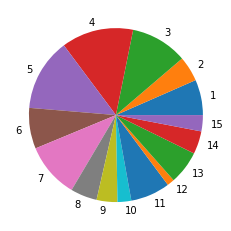

In [7]:
#EDA
sdg_counts = df_filtered.groupby("sdg").count()
plt.pie(sdg_counts, labels=sdg_counts.index)
plt.show()

In [8]:
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
porter_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
#Hàm loại bỏ dấu phảy trong câu
def remove_punctuation(description):
    """The function to remove punctuation"""
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)

#Hàm loại bỏ các từ thừa, không có ý nghĩa trong câu
def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)


#Hàm để tìm dạng gốc của từ
#VD loves thì dạng gốc của từ sẽ là love
def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter_stemmer.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [10]:
#Sử dụng hàm cho cột "text"
df_filtered["text"] = df_filtered["text"].apply(remove_punctuation)
df_filtered["text"] = df_filtered["text"].apply(remove_stopwords)
df_filtered["text"] = df_filtered["text"].apply(stemmer)
df_filtered.head()

,sdg,text
0,5,gender perspect paulgaard point labour market ...
2,3,averag figur also mask larg differ across regi...
7,6,israel oceanograph limnolog research station m...
8,2,previou chapter discuss way make food system s...
11,8,prescript rate appear higher labour forc parti...


In [11]:
#Lấy thử 1 text đã qua xử lý
df_filtered["text"].iloc[1]

'averag figur also mask larg differ across region kazakhstan number annual contact rang 20 astana 97 mangystau part popul like limit access primari care addit poor coverag outpati prescript medicin limit effect appeal care phc level'

In [12]:
#Chia data để train và test
X = df_filtered["text"]
y = df_filtered["sdg"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14104,), (3527,), (14104,), (3527,))

In [13]:
#Logistic Regression model

model_log = Pipeline([
  ('vect', CountVectorizer(min_df=5, ngram_range=(1,2))), #Chuyển thành vector, bỏ qua những từ xuất hiện dưới 5 lần, xét theo cặp từ
  ('tfidf', TfidfTransformer()), #Tính Tf-idf vector, Tf-idf giúp chuyển đổi dạng biểu diễn văn bản thành dạng vector
  ('model',LogisticRegression()), 
 ])

model_log.fit(X_train, y_train)

ytest = np.array(y_test)
ypred_lg = model_log.predict(X_test)
print(f"accuracy: {accuracy_score(ypred_lg, y_test)}")
print(classification_report(ytest, ypred_lg))

accuracy: 0.8772327757300822
              precision    recall  f1-score   support

           1       0.84      0.80      0.82       237
           2       0.90      0.87      0.89       165
           3       0.88      0.94      0.91       360
           4       0.92      0.97      0.94       465
           5       0.90      0.95      0.92       464
           6       0.97      0.93      0.95       290
           7       0.86      0.95      0.90       356
           8       0.75      0.69      0.72       180
           9       0.76      0.76      0.76       127
          10       0.79      0.51      0.62        90
          11       0.83      0.83      0.83       251
          12       0.78      0.44      0.57        63
          13       0.84      0.90      0.87       194
          14       0.96      0.91      0.94       159
          15       0.92      0.77      0.84       126

    accuracy                           0.88      3527
   macro avg       0.86      0.82      0.83      35

In [14]:
#Stochastic Gradient Descent Classifier model
pipeline = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('clf', SGDClassifier(
      loss='modified_huber',
      penalty='l2',
      alpha=1e-3,
      random_state=42,
      max_iter=100,
      tol=None,
      )),
])
classifier = pipeline.fit(X_train, y_train)
ytest = np.array(y_test)
ypred_sgd = classifier.predict(X_test)
print(f"accuracy: {accuracy_score(ypred_sgd, y_test)}")
print(classification_report(ytest, ypred_sgd))

accuracy: 0.884604479727814
              precision    recall  f1-score   support

           1       0.87      0.82      0.84       237
           2       0.88      0.88      0.88       165
           3       0.90      0.95      0.92       360
           4       0.91      0.97      0.94       465
           5       0.90      0.96      0.93       464
           6       0.95      0.95      0.95       290
           7       0.88      0.95      0.91       356
           8       0.75      0.67      0.71       180
           9       0.82      0.75      0.78       127
          10       0.81      0.49      0.61        90
          11       0.84      0.83      0.84       251
          12       0.76      0.49      0.60        63
          13       0.86      0.90      0.88       194
          14       0.96      0.94      0.95       159
          15       0.92      0.81      0.86       126

    accuracy                           0.88      3527
   macro avg       0.87      0.82      0.84      352

In [15]:
#Random Forest Classifier
rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
  ('tfidf', TfidfTransformer()),
  ('rf', RandomForestClassifier(n_estimators=50)),
])

rf.fit(X_train, y_train)
ytest = np.array(y_test)
ypred_rf = rf.predict(X_test)
print(f"accuracy: {accuracy_score(ypred_rf, y_test)}")
print(classification_report(ytest, ypred_rf))

accuracy: 0.832151970513184
              precision    recall  f1-score   support

           1       0.75      0.82      0.78       237
           2       0.81      0.82      0.81       165
           3       0.86      0.92      0.89       360
           4       0.84      0.97      0.90       465
           5       0.85      0.95      0.90       464
           6       0.91      0.94      0.93       290
           7       0.81      0.93      0.87       356
           8       0.66      0.47      0.55       180
           9       0.80      0.50      0.62       127
          10       0.88      0.32      0.47        90
          11       0.76      0.75      0.76       251
          12       0.88      0.24      0.37        63
          13       0.82      0.87      0.85       194
          14       0.92      0.89      0.90       159
          15       0.95      0.70      0.80       126

    accuracy                           0.83      3527
   macro avg       0.83      0.74      0.76      352

In [16]:
#Multinomial Naive Bayes model
nbc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
  ('tfidf', TfidfTransformer()),
  ('model',MultinomialNB()),
])

nbc.fit(X_train, y_train)
ytest = np.array(y_test)
ypred_nb = nbc.predict(X_test)
print(f"accuracy: {accuracy_score(ypred_nb, y_test)}")
print(classification_report(ytest, ypred_nb))

accuracy: 0.7147717607031472
              precision    recall  f1-score   support

           1       0.80      0.66      0.72       237
           2       0.97      0.41      0.58       165
           3       0.86      0.93      0.89       360
           4       0.72      0.98      0.84       465
           5       0.54      0.99      0.70       464
           6       0.87      0.89      0.88       290
           7       0.57      0.97      0.72       356
           8       1.00      0.04      0.07       180
           9       1.00      0.02      0.05       127
          10       0.00      0.00      0.00        90
          11       0.89      0.67      0.77       251
          12       0.00      0.00      0.00        63
          13       0.88      0.76      0.82       194
          14       0.98      0.55      0.70       159
          15       0.97      0.22      0.36       126

    accuracy                           0.71      3527
   macro avg       0.74      0.54      0.54      35

In [17]:
#So sánh độ chính xác của các model 
lr_acc = accuracy_score(ypred_lg, y_test)
sgd_acc = accuracy_score(ypred_sgd, y_test)
nb_acc = accuracy_score(ypred_nb, y_test)
rf_acc = accuracy_score(ypred_rf, y_test)

#Creating a new dataframe containing all the model names and their corresponding accuracies.
models = pd.DataFrame({
                      'Model': ["Logistic Regression", "SGD Classifier", "Naive Bayes", "Random Forest"],
                      'Score': [lr_acc, sgd_acc, nb_acc, rf_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,SGD Classifier,0.884604
0,Logistic Regression,0.877233
3,Random Forest,0.832152
2,Naive Bayes,0.714772


**=> SGD Classifier cho độ chính xác cao nhất nên với task này ta sẽ sử dụng model SGD Classifier**

In [18]:
#Tuning the parameters for SGD Model

pipeline = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('clf', SGDClassifier(
      loss='squared_hinge', #old: modified_huber
      penalty='l2',
      alpha=1e-3,
      random_state=42,
      max_iter=100,
      tol=None,
      )),
])
classifier = pipeline.fit(X_train, y_train)
ytest = np.array(y_test)
ypred_sgd = classifier.predict(X_test)
print(f"accuracy: {accuracy_score(ypred_sgd, y_test)}")
print(classification_report(ytest, ypred_sgd))

accuracy: 0.8848880068046499
              precision    recall  f1-score   support

           1       0.87      0.82      0.84       237
           2       0.88      0.88      0.88       165
           3       0.90      0.95      0.92       360
           4       0.91      0.97      0.94       465
           5       0.90      0.96      0.93       464
           6       0.95      0.95      0.95       290
           7       0.88      0.95      0.91       356
           8       0.75      0.67      0.71       180
           9       0.82      0.75      0.78       127
          10       0.83      0.49      0.62        90
          11       0.84      0.83      0.84       251
          12       0.76      0.49      0.60        63
          13       0.86      0.90      0.88       194
          14       0.96      0.94      0.95       159
          15       0.92      0.81      0.86       126

    accuracy                           0.88      3527
   macro avg       0.87      0.83      0.84      35

[[194   1   5   5   9   2   1   9   0   4   6   0   1   0   0]
 [  2 146   4   0   5   0   2   0   2   1   1   0   0   0   2]
 [  1   0 341   2   8   1   0   1   1   0   5   0   0   0   0]
 [  0   0   3 452   5   0   3   1   1   0   0   0   0   0   0]
 [  2   0   3   8 447   0   0   2   0   1   0   0   0   0   1]
 [  0   2   0   0   1 276   1   0   1   0   2   0   6   0   1]
 [  0   1   0   1   1   0 338   0   2   0   6   1   5   0   1]
 [  9   3   4  14  12   0   4 121   6   3   4   0   0   0   0]
 [  2   2   0   5   1   0   3   7  95   0   7   0   4   0   1]
 [ 13   1   6   3   4   0   1  13   1  44   3   0   1   0   0]
 [  0   1   4   4   2   5  13   2   3   0 209   5   2   0   1]
 [  1   5   5   0   1   1   7   4   1   0   3  31   4   0   0]
 [  0   1   0   1   1   2   9   1   1   0   0   1 175   1   1]
 [  0   0   3   0   0   2   0   0   0   0   0   1   2 150   1]
 [  0   2   3   0   1   3   1   0   2   0   2   2   3   5 102]]


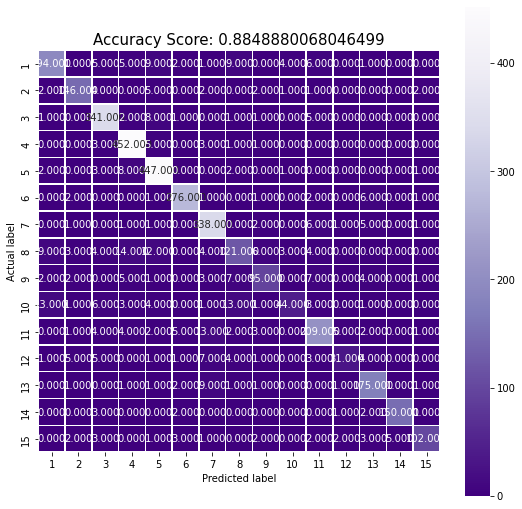

In [20]:
#Confusion Matrix
from sklearn import metrics
con_matrix = metrics.confusion_matrix(ytest, ypred_sgd)
print(con_matrix)

plt.figure(figsize=(9,9))
sns.heatmap(con_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Purples_r', xticklabels=range(1, 16), yticklabels=range(1,16));
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(ypred_sgd, y_test))
plt.title(all_sample_title, size = 15);